#### Imports

In [ ]:
!pip install geneticalgorithm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15077 sha256=d966d3e1b21d049f86a495a2044ca6cb8c4b7e879d945bcf17f5c23a10c0d96f
  Stored in directory: /root/.cache/pip/wheels/3f/83/19/b5552bb9630e353f7c5b15be44bf10900afe1abbbfcf536afd
Successfully built func-timeout


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest

from itertools import combinations
from geneticalgorithm import geneticalgorithm as ga

In [ ]:
# Setting up the plot aesthetics
sns.set(style="whitegrid")

In [ ]:
# Load the CSV file to check its structure
# https://www.kaggle.com/datasets/patricknaylor/its-rugby-player-data
player_data = pd.read_csv('/content/itsrugby_players.csv')

## Understanding the data

In [ ]:
# Display the first few rows and column names
player_data.head(), player_data.columns

(             player_id   birthdate        pos  year   team  \
 0  esteban-abadie-4289  01/12/1997  Third Row  2022  Brive   
 1  esteban-abadie-4289  01/12/1997  Third Row  2021  Brive   
 2  esteban-abadie-4289  01/12/1997  Third Row  2021  Brive   
 3  esteban-abadie-4289  01/12/1997  Third Row  2020  Brive   
 4  esteban-abadie-4289  01/12/1997  Third Row  2020  Brive   
 
                     competition   pts  played  start  try  pen   dp   tr  \
 0                        Top 14   0.0     2.0    2.0  0.0  0.0  0.0  0.0   
 1  European Rugby Challenge Cup   0.0     1.0    0.0  0.0  0.0  0.0  0.0   
 2                        Top 14  10.0    20.0   14.0  2.0  0.0  0.0  0.0   
 3  European Rugby Challenge Cup   0.0     2.0    2.0  0.0  0.0  0.0  0.0   
 4                        Top 14   0.0     8.0    3.0  0.0  0.0  0.0  0.0   
 
    yellow  red     min  
 0     0.0  0.0   160.0  
 1     0.0  0.0    29.0  
 2     0.0  0.0  1185.0  
 3     0.0  0.0   136.0  
 4     1.0  0.0   315.0  ,

### 1. Player consistency (no. of matches vs. points scored)

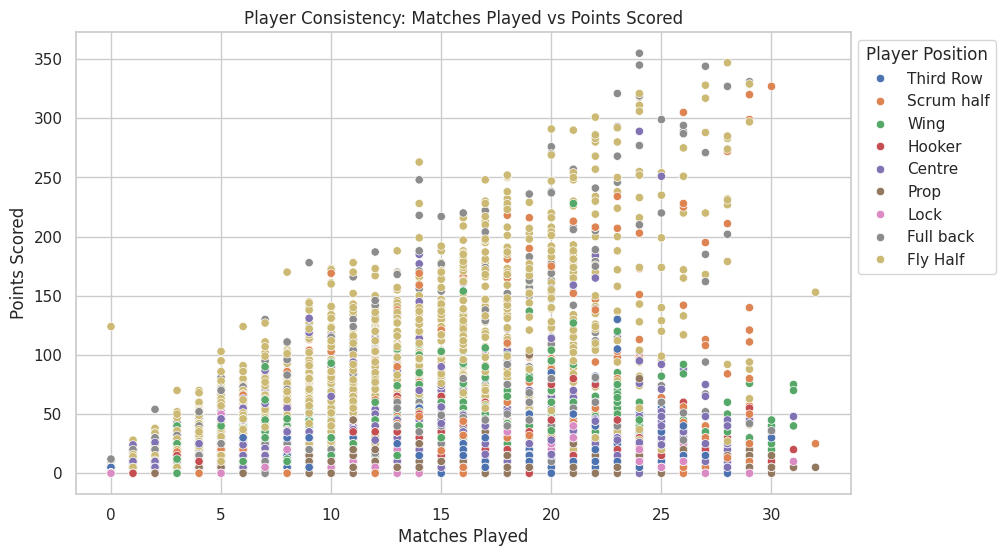

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='played', y='pts', hue='pos', data=player_data)
plt.title('Player Consistency: Matches Played vs Points Scored')
plt.xlabel('Matches Played')
plt.ylabel('Points Scored')
plt.legend(title='Player Position', bbox_to_anchor=(1, 1))
plt.show()

#### Analysis
* **Fly Halves** are key contributors to points across multiple matches
* Forward positions, like **Prop** and **Hooker**, focus more on tactical and defensive roles rather than scoring
* Certain positions, like **Wing** and **Full back**, show a large variation in scoring, indicating that individual players' contributions can vary widely depending on game dynamics

### 2. Key plays (sum of `try` + `pen` + `tr`) per position

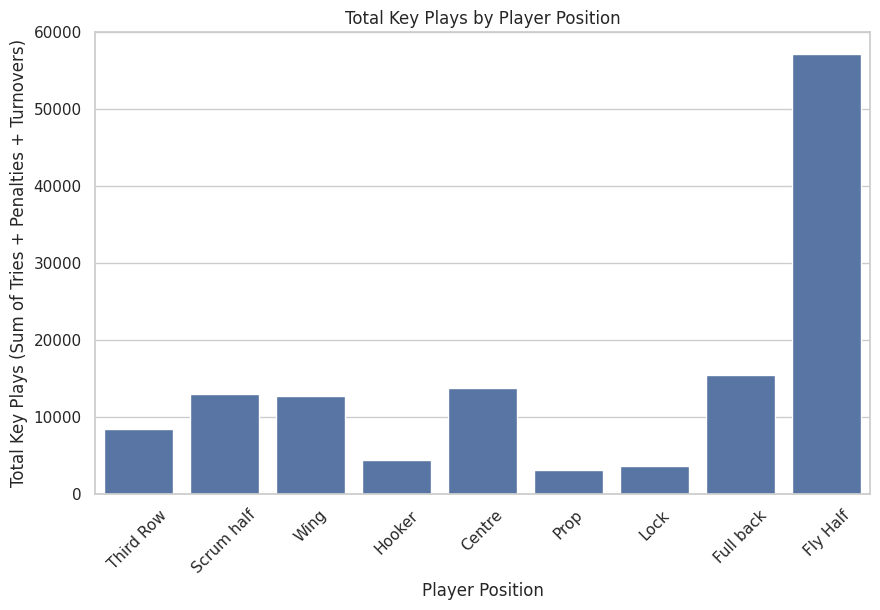

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='pos', y='key_plays', data=player_data, estimator=sum, errorbar=None)
plt.title('Total Key Plays by Player Position')
plt.xlabel('Player Position')
plt.ylabel('Total Key Plays (Sum of Tries + Penalties + Turnovers)')
plt.xticks(rotation=45)
plt.show()

#### Analysis
* **Fly Half** leads in total key plays
* **Scrum half**, **Wing**, and **Full back** also show significant contributions (imp. for roles in game strategy and execution)
* **Forward players** contribute less to the particular key metrics (focus more on other tactical and physical aspects)

### 3. Variation in player performance (home vs. away/ against "strong" opponents)

In [ ]:
# add when data available

#### Analysis

### 4. Field time vs. player role & performance

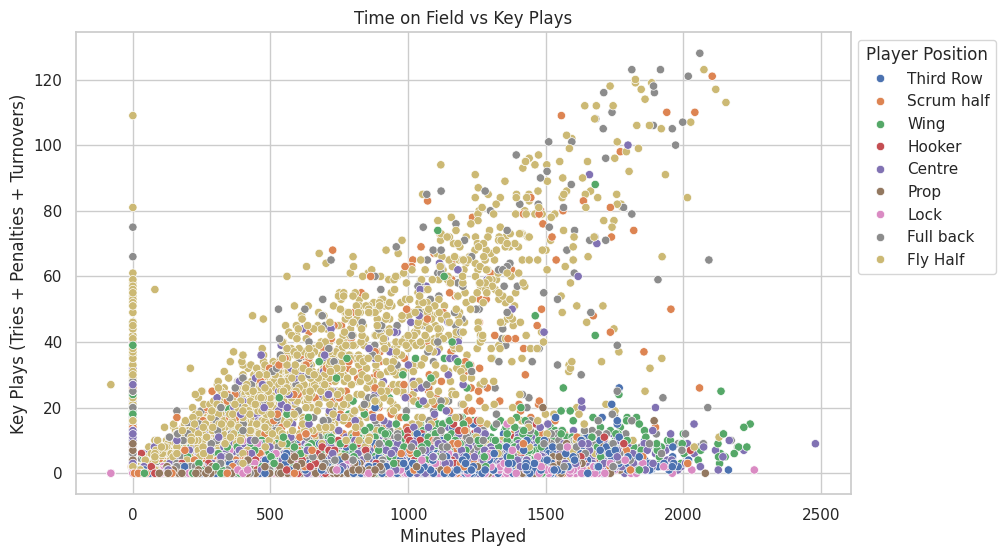

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='min', y='key_plays', hue='pos', data=player_data)
plt.title('Time on Field vs Key Plays')
plt.xlabel('Minutes Played')
plt.ylabel('Key Plays (Tries + Penalties + Turnovers)')
plt.legend(title='Player Position', bbox_to_anchor=(1, 1))
plt.show()

### Analysis
* **Fly Half** is the most critical position in terms of making key plays, regardless of field time
  - involved in the majority of tries, penalties, and turnover
* **Scrum half**, **Wing**, and **Full back** also play significant roles in influencing match outcomes
  - especially with more time on the field
* **Forward players** tend to contribute less to key plays
  - more focused on the physical aspects of the game

## Exploratory data analysis (EDA)

### 1. Correlations between variables

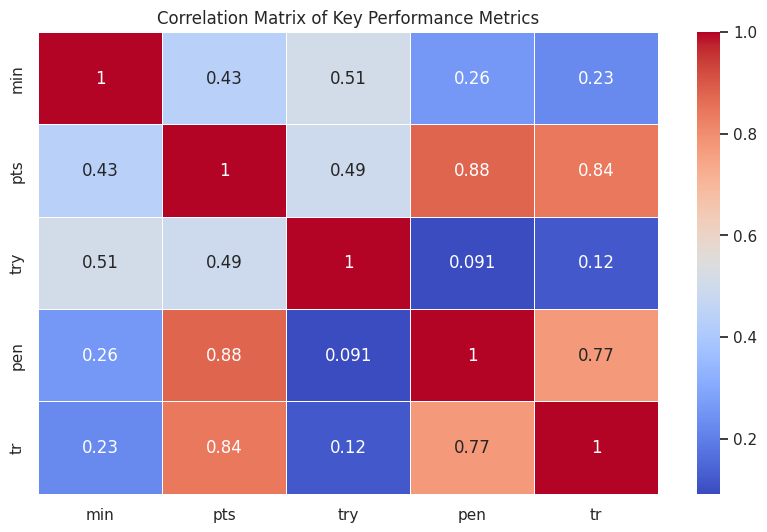

In [ ]:
# Correlation matrix for key numerical metrics
plt.figure(figsize=(10, 6))
corr = player_data[['min', 'pts', 'try', 'pen', 'tr']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Key Performance Metrics')
plt.show()

#### Analysis

**High correlations**

* `pts` and `pen`: 0.88
  - players who score more points often contribute heavily through penalties
* `pts` and `tr`: 0.84
  - players who engage in crucial defensive plays also capitalise on scoring opportunities
* `pen` and `tr`: 0.77
  - players involved in winning turnovers may also be responsible for taking penalty kicks or capitalising on penalties

**Moderate correlations**

* `min` and `try`: 0.51  
  - players who spend more time on the field are slightly more likely to score tries, though the
  - relationship is not exceedingly strong
* `pts` and `try`: 0.49
  - players who score more tries are also likely to score more points overall
  - not all points come from tries alone
* `min` and `pts`: 0.43  
  - more playing time is associated with higher point contributions
  - other factors (e.g., position) also influence points scored


**Weak correlations**

* `min` and `tr`: 0.23
  - time on the field does not necessarily correlate strongly with turnovers (turnovers are more related to position and play style)
* `try` and `pen`: 0.091 between tries and penalties
  - players who score tries are not typically the same players who score through penalties

### 2. Performance w.r.t player position

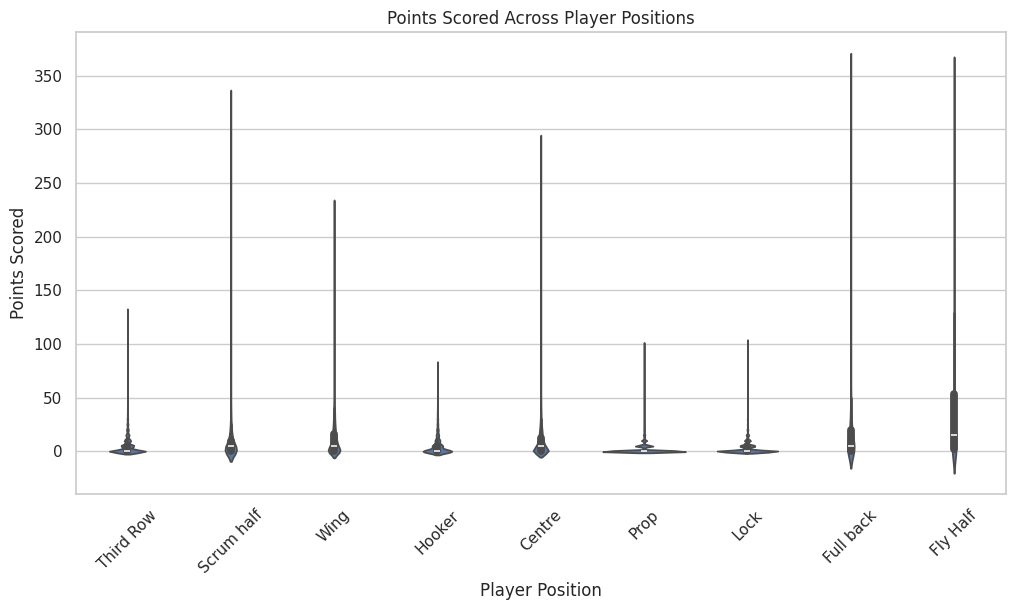

In [ ]:
# Violin plot to compare points scored across positions
plt.figure(figsize=(12, 6))
sns.violinplot(x='pos', y='pts', data=player_data)
plt.title('Points Scored Across Player Positions')
plt.xlabel('Player Position')
plt.ylabel('Points Scored')
plt.xticks(rotation=45)
plt.show()

#### Analysis

* **Fly Halves**, **Full backs**, and **Scrum halves** contribute to the most points scored
  - exhibit wide distributions with some high-scoring players
* **Wings** and **Centres** also contribute to scoring
  - fewer extreme outliers
* **Forwards** don't contribute much to point-scoring
  - roles more focused on physical and defensive tasks

### 3. Finding similar-performing players

<ipython-input-6-2122d203681c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


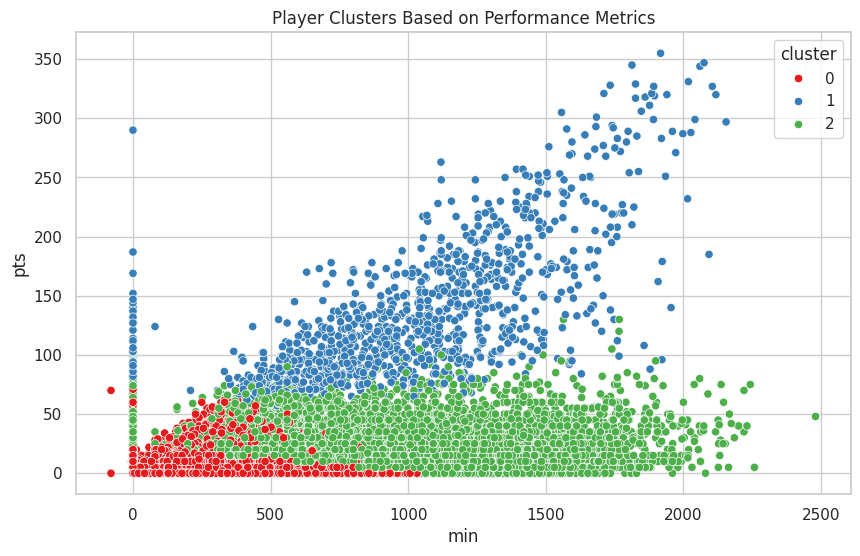

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Selecting performance metrics for clustering
X = player_data[['min', 'pts', 'try', 'pen', 'tr']]

# Handling missing values (e.g., fill with 0)
X.fillna(0, inplace=True)

# Standardizing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(X_scaled)

# Adding clusters to the dataset
player_data['cluster'] = clusters

# Visualizing clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='min', y='pts', hue='cluster', data=player_data, palette='Set1')
plt.title('Player Clusters Based on Performance Metrics')
plt.show()


#### Analysis

* Cluster 0 (**red**) represents **players with limited impact** in terms of playtime and scoring.
* Cluster 1 (**blue**) includes **moderately consistent players** who contribute regularly but are not the top scorers.
* Cluster 2 (**green**) highlights the **standout performers**, whose significant contributions can be seen both in terms of points and minutes played.

### 4. Player performance over time

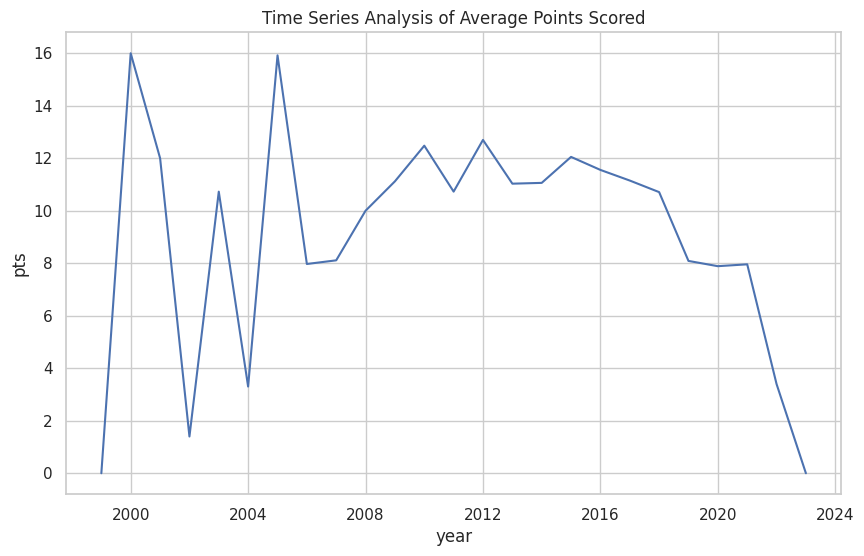

In [ ]:
player_data['year'] = pd.to_datetime(player_data['year'], format='%Y')  # If year is numeric
time_series_data = player_data.groupby('year').agg({'pts': 'mean'}).reset_index()

# Plotting time series
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='pts', data=time_series_data)
plt.title('Time Series Analysis of Average Points Scored')
plt.show()


#### Analysis
* **Changes in rugby rules** over the years could impact scoring trends
* **Frequent player rotation** could reduce individual contributions, leading to a drop in average points
* **Other external factors** may also play a part in reduced scoring



### 5. Key plays w.r.t position

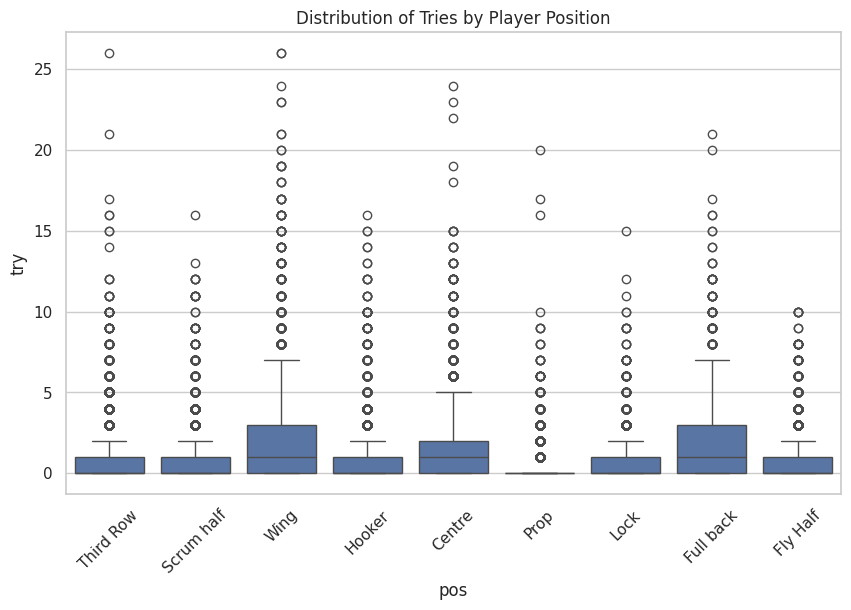

In [ ]:
# Boxplot for distribution of tries by position
plt.figure(figsize=(10, 6))
sns.boxplot(x='pos', y='try', data=player_data)
plt.title('Distribution of Tries by Player Position')
plt.xticks(rotation=45)
plt.show()

#### Analysis

* **Wings** and **Full backs** have the highest median number of tries and the widest distribution
  - these positions are more likely to score tries
* **Fly halves** and **Scrum halves** also show a wide distribution
  - generally have a lower median number of tries compared to **Wings** and **Full backs**
  - tend to focus on playmaking, kicking, and organising the attack rather than finishing tries
* **Third Rows**, **Hookers**, **Props**, and **Locks** show the lowest median and distribution of tries
  - more focused on physical confrontations rather than scoring tries
* Outliers across all positions indicate that a few exceptional players in each position score significantly more tries than the average

### 6. Player consistency w.r.t. games/seasons

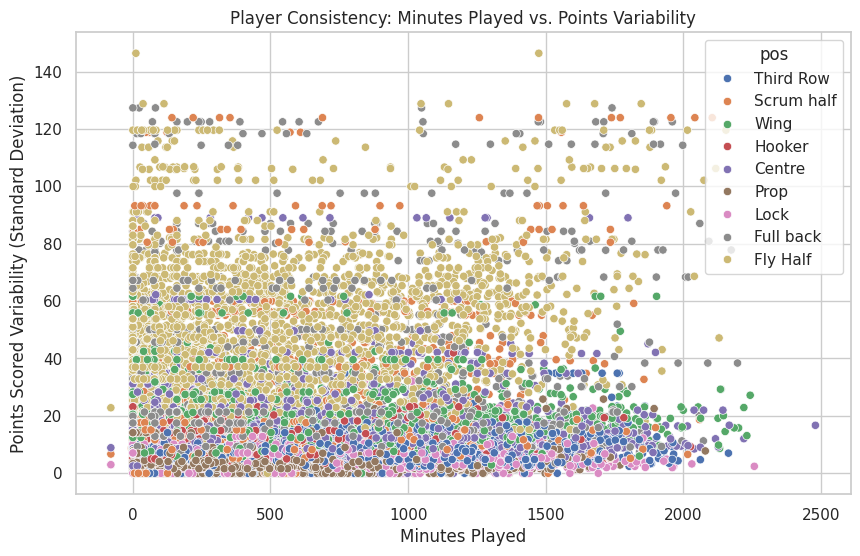

In [ ]:
# Calculate standard deviation of points scored for each player to measure consistency
consistency = player_data.groupby('player_id').agg({'pts': 'std'}).reset_index()
consistency.columns = ['player_id', 'points_std']

# Merge with original data and plot
data_consistency = pd.merge(player_data, consistency, on='player_id')

plt.figure(figsize=(10, 6))
sns.scatterplot(x='min', y='points_std', hue='pos', data=data_consistency)
plt.title('Player Consistency: Minutes Played vs. Points Variability')
plt.xlabel('Minutes Played')
plt.ylabel('Points Scored Variability (Standard Deviation)')
plt.show()


#### Analysis

* **Fly Halves**, **Full backs**, and **Scrum halves** exhibit more variability in scoring points
  - can have big games but may not always deliver consistent performance
* **Forwards** tend to be more consistent in their lower-scoring contributions

* Despite playing more minutes, many players still exhibit variability  
  - scoring consistency is more dependent on the player's role and game dynamics as opposed to no. of mins played

### 7. Player contribution w.r.t. high stake games

In [ ]:
# add when data available

#### Analysis

### 8. Interactively explore relationships

In [ ]:
import plotly.express as px

# Interactive scatter plot
player_data = player_data.dropna(subset=['try'])
fig = px.scatter(player_data, x='min', y='pts', color='pos', size='try', hover_name='player_id',
                 title="Minutes Played vs Points Scored (Totally)")
fig.show()

#### Analysis

* **Fly Half** (pink) and **Full back** (green) have larger bubble sizes (tries)
  - players are more involved in scoring and key plays
* **Hookers** (blue) contribute fewer points but still participate in key plays
* **Wings** (green) and **Scrum halves** (orange) are spread across various levels of scoring


## Feature relationships

To analyse the dataset for feature relationships and answer the following questions:

1. Do players who cover more distance tend to perform better?
2. Is there a correlation between successful tackles and overall performance ratings?
3. Does playing in certain positions (forward vs defence) lead to significantly different performance outcomes?

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



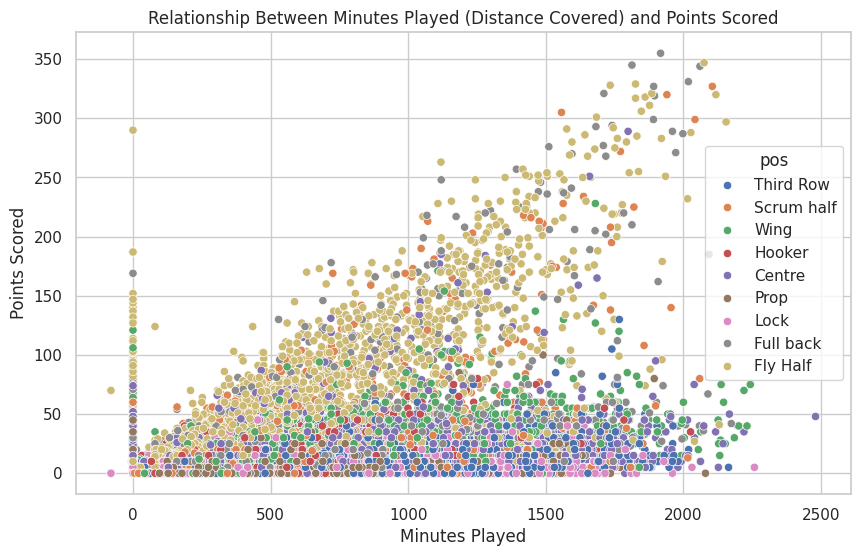

In [ ]:
# Scatter plot to check relationship between minutes played (proxy for distance covered) and points scored
plt.figure(figsize=(10, 6))
sns.scatterplot(x='min', y='pts', hue='pos', data=player_data)
plt.title('Relationship Between Minutes Played (Distance Covered) and Points Scored')
plt.xlabel('Minutes Played')
plt.ylabel('Points Scored')
plt.show()


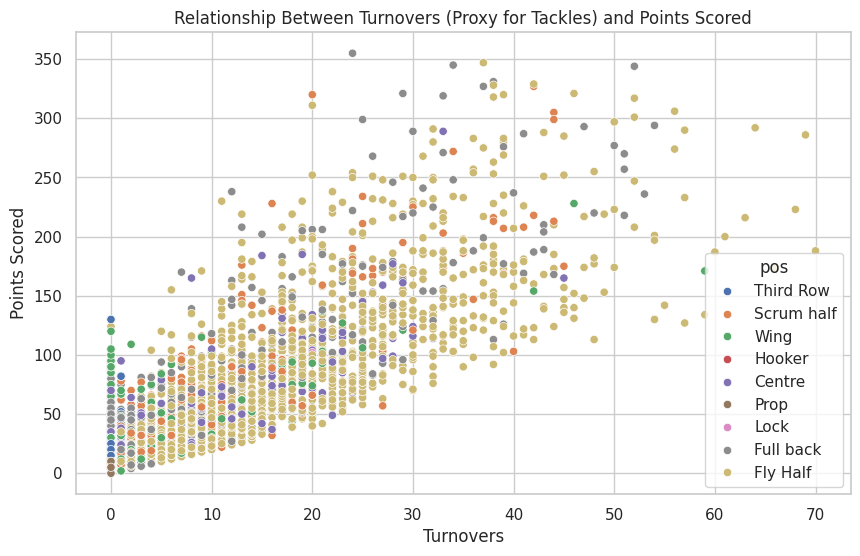

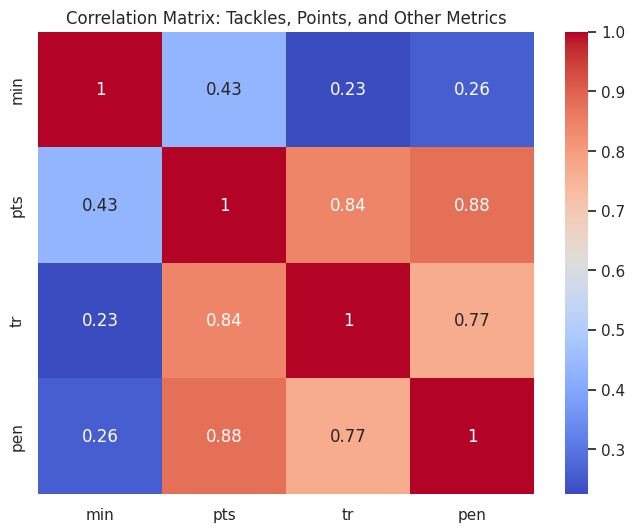

In [ ]:
# Correlation between tackles (proxy) and points scored
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tr', y='pts', hue='pos', data=player_data)
plt.title('Relationship Between Turnovers (Proxy for Tackles) and Points Scored')
plt.xlabel('Turnovers')
plt.ylabel('Points Scored')
plt.show()

# Correlation matrix to find overall relationship
plt.figure(figsize=(8, 6))
corr = player_data[['min', 'pts', 'tr', 'pen']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix: Tackles, Points, and Other Metrics')
plt.show()


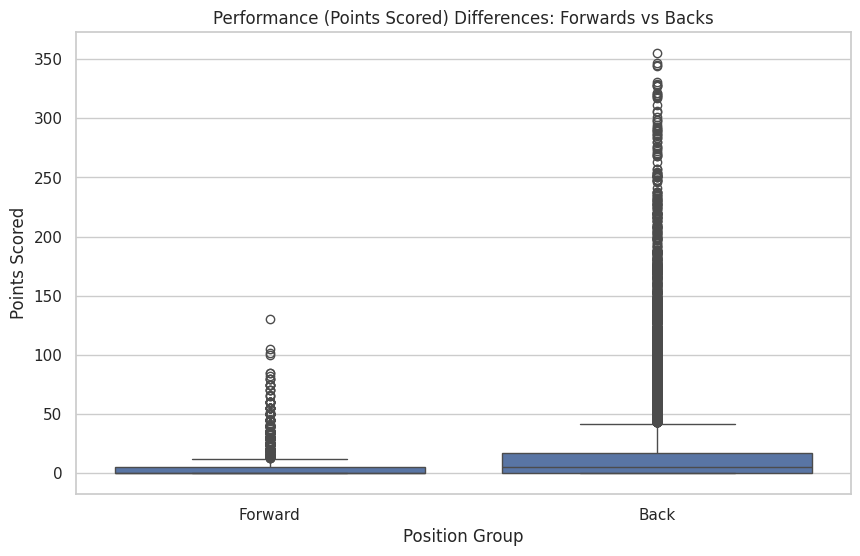

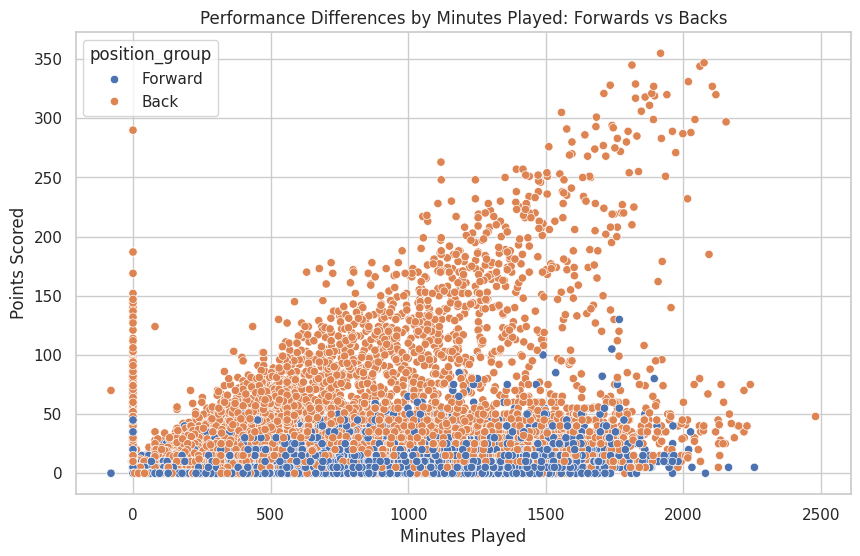

In [ ]:
# Define forwards and backs
forwards = ['Prop', 'Hooker', 'Lock', 'Third Row']
backs = ['Wing', 'Scrum half', 'Centre', 'Full back', 'Fly Half']

# Create a new column for position group
player_data['position_group'] = player_data['pos'].apply(lambda x: 'Forward' if x in forwards else 'Back')

# Visualize performance differences
plt.figure(figsize=(10, 6))
sns.boxplot(x='position_group', y='pts', data=player_data)
plt.title('Performance (Points Scored) Differences: Forwards vs Backs')
plt.xlabel('Position Group')
plt.ylabel('Points Scored')
plt.show()

# Scatter plot for further comparison of performance
plt.figure(figsize=(10, 6))
sns.scatterplot(x='min', y='pts', hue='position_group', data=player_data)
plt.title('Performance Differences by Minutes Played: Forwards vs Backs')
plt.xlabel('Minutes Played')
plt.ylabel('Points Scored')
plt.show()


#### Inference

* Distance vs Performance: By using minutes as a proxy, you can identify whether more active players (higher minutes) also score more points, which might correlate with distance covered.
* Tackles vs Performance: If turnovers or penalties are a good stand-in for defensive actions, this will help reveal if more active defenders also contribute to team success.
* Forwards vs Backs: This analysis can reveal whether different playing styles (forwards vs backs) lead to differing performance metrics, such as points scored or contributions to key plays.

## Performance prediction

### 1. Data preparation
* Handle missing values
* Encode categorical (non-numeric) variables
* Split data into training and testing sets


In [ ]:
# Handle missing values (if necessary)
player_data.fillna(0, inplace=True)

# Encode categorical variables (like player positions)
encoder = LabelEncoder()
player_data['pos_encoded'] = encoder.fit_transform(player_data['pos'].astype(str))

# Define features (e.g., minutes played, tackles, penalties, turnovers) and target (e.g., points scored)
features = player_data[['min', 'try', 'pen', 'tr', 'pos_encoded']]
target = player_data['pts']  # Predicting points scored

# Split into train and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 2. Regression model
Predict performance metrics (e.g., points scored) based on features like minutes played, tackles, penalties, etc.


In [ ]:
# Train a linear regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Predictions
y_pred = reg_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# What-if: Predict points with increased minutes (e.g., +500 mins)
increased_minutes = X_test.copy()
increased_minutes[:, 0] += 500  # Adding 500 minutes
y_pred_increased = reg_model.predict(increased_minutes)
print(f'Predicted Points with Increased Minutes: {y_pred_increased}')

Mean Squared Error: 0.8928196282207312
R-squared: 0.998356835591016
Predicted Points with Increased Minutes: [66.97150022 66.98444084 66.96401184 ... 67.02994809 66.96900409
 66.95901959]


### 3. Classification model
Classifying players into high, medium, or low performers based on past performance data.

* High performers: Points scored > 100.
* Medium performers: 50 < Points scored ≤ 100.
* Low performers: Points scored ≤ 50.

In [ ]:
# Create a new column for performance bands
def performance_band(points):
    if points > 100:
        return 'High'
    elif 50 < points <= 100:
        return 'Medium'
    else:
        return 'Low'

player_data['performance_band'] = player_data['pts'].apply(performance_band)

# Encode performance bands
player_data['performance_band_encoded'] = encoder.fit_transform(player_data['performance_band'])

# Features and target for classification
features_classification = player_data[['min', 'try', 'pen', 'tr', 'pos_encoded']]
target_classification = player_data['performance_band_encoded']

# Split into train and test sets
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(features_classification, target_classification, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_clf, y_train_clf)

# Predictions
y_pred_clf = clf.predict(X_test_clf)

# Evaluate the model
print(classification_report(y_test_clf, y_pred_clf, target_names=encoder.classes_))

# Feature importance
importances = clf.feature_importances_
print(f'Feature importances: {importances}')


              precision    recall  f1-score   support

        High       0.96      0.97      0.97       136
         Low       1.00      1.00      1.00      9793
      Medium       0.97      0.92      0.94       201

    accuracy                           1.00     10130
   macro avg       0.98      0.96      0.97     10130
weighted avg       1.00      1.00      1.00     10130

Feature importances: [0.06335861 0.14904884 0.41758498 0.35239323 0.01761434]


In [ ]:
# Step 1: Train-test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    features_classification, target_classification, test_size=0.2, random_state=42)

# Step 2: Predict the performance band for the test set
y_pred_clf = clf.predict(X_test_clf)  # Predictions for test set

# Step 3: Add the predicted bands to the test set
# Create a DataFrame to hold player information, test features, and predicted performance band
# Assuming 'data' contains player information and features_classification contains the relevant features for the model

# Create a DataFrame for the test set with the same length as X_test_clf
players_test_set = pd.DataFrame(X_test_clf, columns=features_classification.columns)

# Add the predicted performance bands to this DataFrame
players_test_set['predicted_band'] = y_pred_clf

# Optional: Map back to original performance band labels (High, Medium, Low)
players_test_set['predicted_band_name'] = encoder.inverse_transform(players_test_set['predicted_band'])

# Step 4: Simply print the players in each performance band (High, Medium, Low)
# Example: Get high-performing players
print("High Performers:")
high_performers = players_test_set[players_test_set['predicted_band_name'] == 'High']
print(high_performers)

# Example: Get medium-performing players
print("Medium Performers:")
medium_performers = players_test_set[players_test_set['predicted_band_name'] == 'Medium']
print(medium_performers)

# Example: Get low-performing players
print("Low Performers:")
low_performers = players_test_set[players_test_set['predicted_band_name'] == 'Low']
print(low_performers)


High Performers:
          min  try   pen    tr  pos_encoded  predicted_band  \
20121  1492.0  3.0  19.0  18.0            2               0   
807    1861.0  7.0  69.0  38.0            2               0   
8947   1472.0  1.0  65.0  20.0            2               0   
14442  1923.0  2.0  41.0  23.0            2               0   
10683  1718.0  3.0  67.0  26.0            3               0   
...       ...  ...   ...   ...          ...             ...   
49158   932.0  2.0  15.0  26.0            2               0   
3328   1369.0  0.0  43.0  26.0            2               0   
41573   601.0  1.0  25.0  18.0            2               0   
5601   1132.0  4.0  21.0  10.0            9               0   
31726   694.0  2.0  22.0  24.0            2               0   

      predicted_band_name  
20121                High  
807                  High  
8947                 High  
14442                High  
10683                High  
...                   ...  
49158                High  
33

In [ ]:
# Assuming 'data' contains a 'player_name' or 'player_id' column
# We want to split both the features and the player names/IDs to avoid index misalignment

# Step 1: Split the features and the player names/IDs
X_train_clf, X_test_clf, y_train_clf, y_test_clf, player_train, player_test = train_test_split(
    features_classification, target_classification, player_data['player_id'], test_size=0.2, random_state=42)

# Step 2: Predict the performance band for the test set
y_pred_clf = clf.predict(X_test_clf)

# Step 3: Create a DataFrame to hold player information and the predicted performance band
players_test_set = pd.DataFrame(X_test_clf, columns=features_classification.columns)

# Add the predicted performance bands to this DataFrame
players_test_set['predicted_band'] = y_pred_clf
players_test_set['predicted_band_name'] = encoder.inverse_transform(players_test_set['predicted_band'])

# Add the corresponding player names/IDs back to the test set
players_test_set['player_id'] = player_test.reset_index(drop=True)  # Resetting the index to ensure alignment

# Step 4: Print player names categorized by performance bands

# Example: High performers
print("High Performers:")
high_performers = players_test_set[players_test_set['predicted_band_name'] == 'High']
print(high_performers[['player_id', 'predicted_band_name']])

# Example: Medium performers
print("Medium Performers:")
medium_performers = players_test_set[players_test_set['predicted_band_name'] == 'Medium']
print(medium_performers[['player_id', 'predicted_band_name']])

# Example: Low performers
print("Low Performers:")
low_performers = players_test_set[players_test_set['predicted_band_name'] == 'Low']
print(low_performers[['player_id', 'predicted_band_name']])


High Performers:
                      player_id predicted_band_name
20121                       NaN                High
807           takeshi-hino-2681                High
8947   adriaanjohn-carelse-3509                High
14442                       NaN                High
10683                       NaN                High
...                         ...                 ...
49158                       NaN                High
3328      samuel-boissinot-4156                High
41573                       NaN                High
5601    yoshitaka-tokunaga-2653                High
31726                       NaN                High

[137 rows x 2 columns]
Medium Performers:
                   player_id predicted_band_name
39670                    NaN              Medium
47494                    NaN              Medium
43941                    NaN              Medium
46316                    NaN              Medium
41867                    NaN              Medium
...                   

### 4. Impact of fatigue on performance

In [ ]:
# You can add a custom fatigue feature (for example, minutes in the last 10 minutes of a game)
player_data['fatigue_factor'] = player_data['min'].apply(lambda x: x if x > 70 else 0)  # Minutes after 70th minute

# You could train a regression model using this new feature and see its impact on points scored
features_with_fatigue = player_data[['min', 'try', 'pen', 'tr', 'pos_encoded', 'fatigue_factor']]
X_train_fatigue, X_test_fatigue, y_train_fatigue, y_test_fatigue = train_test_split(features_with_fatigue, target, test_size=0.2, random_state=42)

# Train the regression model with the new fatigue factor
reg_model_fatigue = LinearRegression()
reg_model_fatigue.fit(X_train_fatigue, y_train_fatigue)
y_pred_fatigue = reg_model_fatigue.predict(X_test_fatigue)

# Evaluate the impact of fatigue on points scored
mse_fatigue = mean_squared_error(y_test_fatigue, y_pred_fatigue)
r2_fatigue = r2_score(y_test_fatigue, y_pred_fatigue)
print(f'Mean Squared Error (with Fatigue): {mse_fatigue}')
print(f'R-squared (with Fatigue): {r2_fatigue}')

Mean Squared Error (with Fatigue): 0.892747432669785
R-squared (with Fatigue): 0.9983569684612577


In [ ]:
# Simulate fatigue by reducing minutes in the last 10 minutes of the game
fatigue_minutes = X_test.copy()

# Subtract 10 minutes for each player to simulate the effect of fatigue
fatigue_minutes[:, 0] -= 10  # Reduce minutes by 10 for all players

# Predict points with fatigue
y_pred_fatigue = reg_model.predict(fatigue_minutes)

# Print the predicted points under fatigue conditions
print(f'Predicted Points with Fatigue (Reduced Minutes): {y_pred_fatigue}')

Predicted Points with Fatigue (Reduced Minutes): [-1.35752842 -1.3445878  -1.36501679 ... -1.29908055 -1.36002454
 -1.37000904]


In [ ]:
# Simulate fatigue affecting both minutes and defensive actions (turnovers, penalties)
fatigue_conditions = X_test.copy()

# Reduce minutes played by 10 minutes
fatigue_conditions[:, 0] -= 10  # Reduce minutes

# Reduce defensive work (turnovers, penalties) by 20% due to fatigue
fatigue_conditions[:, 3] *= 0.8  # Reduce turnovers by 20%
fatigue_conditions[:, 2] *= 0.8  # Reduce penalties by 20%

# Predict points under these fatigue conditions
y_pred_fatigue_full = reg_model.predict(fatigue_conditions)

# Print predicted points under full fatigue conditions
print(f'Predicted Points with Full Fatigue (Reduced Minutes and Defensive Work): {y_pred_fatigue_full}')

Predicted Points with Full Fatigue (Reduced Minutes and Defensive Work): [-0.57578062 -0.56284    -0.583269   ... -0.51733275 -0.57827675
 -0.58826125]


## Pattern recognition

### 1. Data preparation
Select key performance metrics such as points scored, minutes played, tackles, penalties, turnovers, etc.

In [ ]:
# Assuming 'data' contains relevant performance metrics such as 'min', 'pts', 'try', 'pen', 'tr'
# Select key performance metrics
performance_metrics = player_data[['min', 'pts', 'try', 'pen', 'tr']]

# Handle missing values (if any)
performance_metrics.fillna(0, inplace=True)

# Standardize the data (important for clustering algorithms)
scaler = StandardScaler()
performance_metrics_scaled = scaler.fit_transform(performance_metrics)

<ipython-input-4-e5e88c6561be>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance_metrics.fillna(0, inplace=True)


### 2. Clustering algorithm (K-means)
Cluster players based on their performance (see [section 2.3](https://colab.research.google.com/drive/1zdxQC48q6-6krNFn9gMFf9b_6YLJeNU6#scrollTo=hRt763CZa-eM&line=1&uniqifier=1))

In [ ]:
# Step 2: Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Change 'n_clusters' based on your analysis
clusters = kmeans.fit_predict(performance_metrics_scaled)

# Add the cluster labels to the original data
player_data['cluster'] = clusters

# Step 3: Analyze the clusters
print(player_data.groupby('cluster').agg({
    'player_id': 'first',  # Just take the first player ID for simplicity. You could also list all IDs
    'min': 'mean',
    'pts': 'mean',
    'try': 'mean',
    'pen': 'mean',
    'tr': 'mean'
}))  # Check the average performance metrics for each cluster


                        player_id         min         pts       try  \
cluster                                                               
0             esteban-abadie-4289  930.705065   20.316613  3.485953   
1             esteban-abadie-4289  213.918901    2.768518  0.378606   
2        jeanpascal-barraque-1791  988.793578  133.345872  2.354128   

               pen         tr  
cluster                        
0         0.511811   0.686789  
1         0.145316   0.213505  
2        24.115596  23.835780  


### 3. Analyse high performing and under performing players

* High-performing players: players in the cluster with the highest average points scored and minutes played.
* Under performing players: players in clusters with lower metrics (e.g., fewer points and minutes).

In [ ]:
# Find high-performing players
high_performing_cluster = player_data[player_data['cluster'] == player_data.groupby('cluster')['pts'].mean().idxmax()]
print("High Performing Players:")
print(high_performing_cluster[['player_id', 'min', 'pts', 'try', 'pen', 'tr']])

# Find underperforming players
underperforming_cluster = player_data[player_data['cluster'] == player_data.groupby('cluster')['pts'].mean().idxmin()]
print("Underperforming Players:")
print(underperforming_cluster[['player_id', 'min', 'pts', 'try', 'pen', 'tr']])


High Performing Players:
                      player_id     min    pts  try   pen    tr
466    jeanpascal-barraque-1791  1154.0   82.0  2.0  20.0   6.0
532        anthony-belleau-3493   955.0   97.0  1.0  22.0  13.0
535        anthony-belleau-3493  1148.0  171.0  0.0  41.0  24.0
537        anthony-belleau-3493  1302.0   98.0  2.0  13.0  23.0
539        anthony-belleau-3493  1245.0  180.0  1.0  33.0  38.0
...                         ...     ...    ...  ...   ...   ...
51091       beaudein-waaka-3001   778.0   93.0  4.0  11.0  20.0
51178       samuel-windsor-3248  1271.0  112.0  1.0  25.0  16.0
51180       samuel-windsor-3248  1261.0  162.0  6.0  28.0  24.0
51181       samuel-windsor-3248   640.0  101.0  4.0  13.0  21.0
51186       samuel-windsor-3248     0.0   91.0  2.0   3.0  25.0

[1090 rows x 6 columns]
Underperforming Players:
                  player_id    min   pts  try  pen   tr
0       esteban-abadie-4289  160.0   0.0  0.0  0.0  0.0
1       esteban-abadie-4289   29.0   0.0  0.0

### 4. Find hidden patterns in under performing players

### 5. Hierarchial clustering (runs out of RAM)

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering
Z = linkage(performance_metrics_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.title('Dendrogram for Hierarchical Clustering')
plt.show()

## Anomaly detection

### 1. Data preperation
Select relevant performance metrics (e.g., minutes played, points scored, tackles, etc.) and calculate each player's average performance across games.

In [ ]:
# Assuming 'data' contains the 'competition' column and relevant performance metrics
# Select key performance metrics
performance_metrics = player_data[['player_id', 'competition', 'min', 'pts', 'try', 'pen', 'tr']]

# Calculate each player's average performance across all competitions
player_avg = performance_metrics.groupby('player_id').agg({'min': 'mean', 'pts': 'mean', 'try': 'mean', 'pen': 'mean', 'tr': 'mean'}).reset_index()
player_avg.rename(columns={'min': 'avg_min', 'pts': 'avg_pts', 'try': 'avg_try', 'pen': 'avg_pen', 'tr': 'avg_tr'}, inplace=True)

# Merge the average metrics back into the main dataset for comparison
performance_metrics = performance_metrics.merge(player_avg, on='player_id')


### 2. Detect under performance based on matches palyed
Calculate Z-scores for each player's performance within each competition to identify whether they significantly underperformed in any given competition.

In [ ]:
# Calculate Z-scores for each player's performance metrics compared to their average
performance_metrics['z_pts'] = (performance_metrics['pts'] - performance_metrics['avg_pts']) / performance_metrics['avg_pts']
performance_metrics['z_min'] = (performance_metrics['min'] - performance_metrics['avg_min']) / performance_metrics['avg_min']

# Identify competitions where the player underperformed (e.g., Z-score less than -1.5)
underperforming_competitions = performance_metrics[(performance_metrics['z_pts'] < -0.5) | (performance_metrics['z_min'] < -1.5)]

print("Under performing matches:")
print(underperforming_competitions[['player_id', 'competition', 'pts', 'min', 'z_pts', 'z_min']])


Under performing matches:
                  player_id                   competition  pts    min  z_pts  \
0       esteban-abadie-4289                        Top 14  0.0  160.0   -1.0   
1       esteban-abadie-4289  European Rugby Challenge Cup  0.0   29.0   -1.0   
3       esteban-abadie-4289  European Rugby Challenge Cup  0.0  136.0   -1.0   
4       esteban-abadie-4289                        Top 14  0.0  315.0   -1.0   
5       esteban-abadie-4289  European Rugby Challenge Cup  0.0  135.0   -1.0   
...                     ...                           ...  ...    ...    ...   
51202      axel-zapata-3683          Super Liga Americana  0.0   80.0   -1.0   
51203     cole-zarcone-4936            Major League Rugby  0.0   42.0   -1.0   
51207  juanpablo-zeiss-2326          Super Liga Americana  0.0  128.0   -1.0   
51208  juanpablo-zeiss-2326                   Super Rugby  0.0  178.0   -1.0   
51209  juanpablo-zeiss-2326                   Super Rugby  0.0   96.0   -1.0   

          z_m

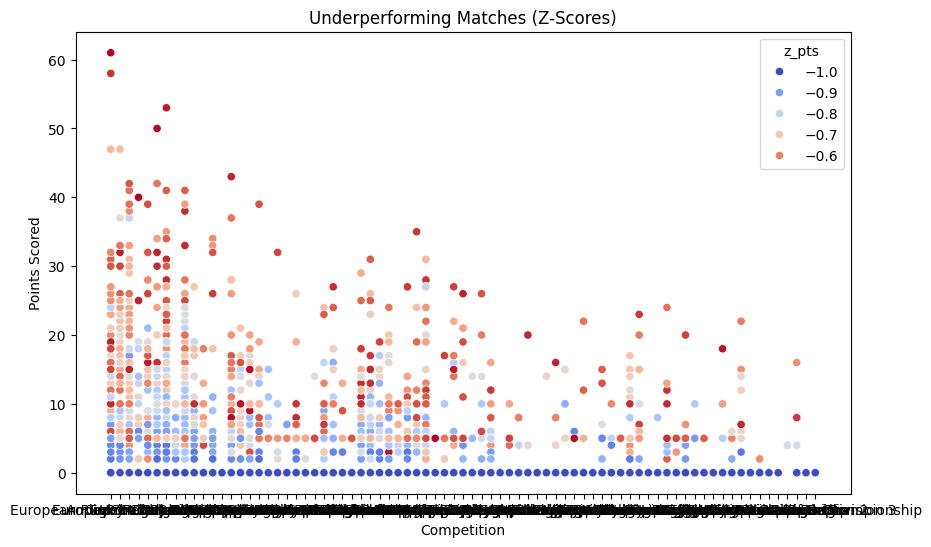

In [ ]:
# Scatter plot to visualize underperforming competitions
# underperforming_subset = underperforming_competitions.sample(n=20, random_state=42)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='competition', y='pts', hue='z_pts', palette='coolwarm', data=underperforming_competitions)
plt.title('Underperforming Matches (Z-Scores)')
plt.xlabel('Competition')
plt.ylabel('Points Scored')
plt.show()

### 3. Detect fatigue or injury trends based on matches
Analyse player performance across different competitions to detect trends of fatigue or injury.

In [ ]:
# Group by player and competition to check performance trends
performance_trend = player_data.groupby(['player_id', 'competition']).agg({'pts': 'sum', 'min': 'sum'}).reset_index()

# Sort by competition (or date) and calculate rolling averages for points and minutes
performance_trend['rolling_avg_pts'] = performance_trend.groupby('player_id')['pts'].rolling(window=3).mean().reset_index(0, drop=True)
performance_trend['rolling_avg_min'] = performance_trend.groupby('player_id')['min'].rolling(window=3).mean().reset_index(0, drop=True)

# Identify players whose rolling average shows a sharp decline across competitions
fatigue_signs = performance_trend[(performance_trend['rolling_avg_pts'].diff() < -10) | (performance_trend['rolling_avg_min'].diff() < -10)]

print("Potential Fatigue/Injury Competitions:")
print(fatigue_signs[['player_id', 'competition', 'pts', 'min', 'rolling_avg_pts', 'rolling_avg_min']])


Potential Fatigue/Injury Competitions:
                player_id                   competition    pts    min  \
4      aaron-carroll-2795                   Super Rugby    0.0   81.0   
5      aaron-carroll-2795          Super Rugby AOTEAROA    0.0   97.0   
10      aaron-cruden-1439                           NPC  206.0   39.0   
13      aaron-cruden-1439          Super Rugby AOTEAROA    0.0  385.0   
15      aaron-cruden-1439                    Top League   20.0  178.0   
...                   ...                           ...    ...    ...   
20100  zarn-sullivan-4521          Super Rugby AOTEAROA    5.0   80.0   
20114  zurab-zhvania-2342  European Rugby Champions Cup   10.0  480.0   
20115  zurab-zhvania-2342          Guinness Premiership    0.0  276.0   
20116  zurab-zhvania-2342                  Heineken Cup    0.0    0.0   
20117  zurab-zhvania-2342         Premiership Rugby Cup    0.0  119.0   

       rolling_avg_pts  rolling_avg_min  
4             6.666667       457.000000  


### 4. Detect player anomalies
Apply Isolation Forest on player performance metrics within each competition to automatically detect anomalies.

In [ ]:
# Use Isolation Forest for anomaly detection
isolation_forest = IsolationForest(contamination=0.05, random_state=42)  # Set contamination based on expected anomaly rate
features = performance_metrics[['pts', 'min', 'try', 'pen', 'tr']]  # Performance metrics for anomaly detection

imputer = SimpleImputer(strategy='mean') # Replace missing values with the mean
features_imputed = imputer.fit_transform(features)

# Pass the imputed features to the fit_predict method
performance_metrics['anomaly'] = isolation_forest.fit_predict(features_imputed)

# Anomalies are labeled as -1, normal points as 1
anomalies = performance_metrics[performance_metrics['anomaly'] == -1]

print("Anomalies Detected in Competitions:")
print(anomalies[['player_id', 'competition', 'pts', 'min', 'anomaly']])

Anomalies Detected in Competitions:
                 player_id                  competition    pts     min  \
12        paul-abadie-3015                       Top 14   52.0  1133.0   
26      mathieu-acebes-621                       Pro D2   23.0  1789.0   
30      mathieu-acebes-621                       Pro D2   45.0  1875.0   
31      mathieu-acebes-621                       Pro D2   60.0  1471.0   
34      mathieu-acebes-621                       Pro D2   30.0  2003.0   
...                    ...                          ...    ...     ...   
51179  samuel-windsor-3248           Major League Rugby   57.0   400.0   
51180  samuel-windsor-3248           Major League Rugby  162.0  1261.0   
51181  samuel-windsor-3248           Major League Rugby  101.0   640.0   
51184  samuel-windsor-3248        British and Irish Cup   37.0   480.0   
51186  samuel-windsor-3248  National Rugby Championship   91.0     0.0   

       anomaly  
12          -1  
26          -1  
30          -1  
31     

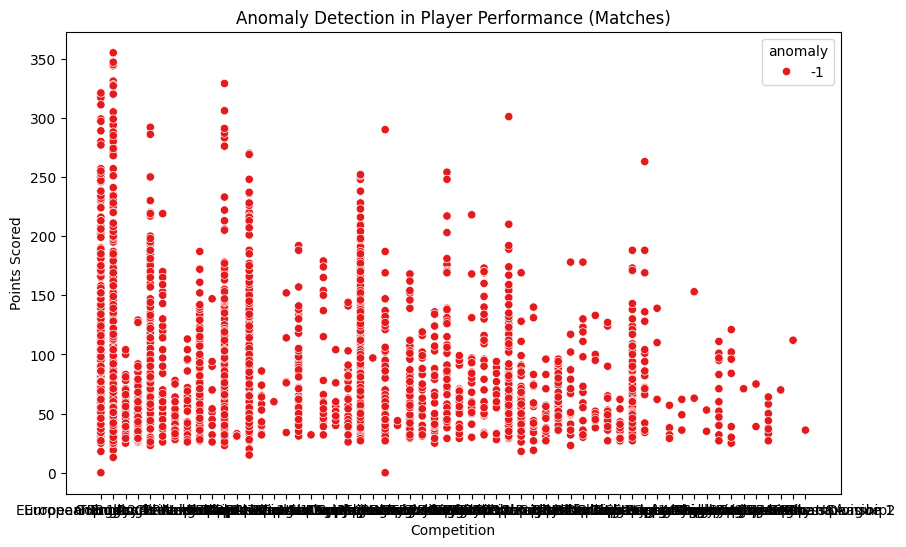

In [ ]:
# Scatter plot to visualize anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(x='competition', y='pts', hue='anomaly', palette='Set1', data=anomalies)
plt.title('Anomaly Detection in Player Performance (Matches)')
plt.xlabel('Competition')
plt.ylabel('Points Scored')
plt.show()

## Performance optimisation (automated)

### 1. Player combination analysis

In [ ]:
# Function to calculate the best player combinations
def get_best_player_combinations(data, top_n=10):
    player_combinations = [] # changed from pd.DataFrame() to []

    for _, group in data.groupby(['competition', 'team']):
        players = group['player_id'].unique()
        combos = list(combinations(players, 2))  # Create pairs of players
        for combo in combos:
            row = {
                'competition': group['competition'].values[0],
                'team': group['team'].values[0],
                'player1': combo[0],
                'player2': combo[1],
                'team_points': group['pts'].sum()
            }
            player_combinations.append(row) # removed ignore_index=True

    player_combinations = pd.DataFrame(player_combinations) # convert list of dicts to DataFrame
    avg_performance_by_pair = player_combinations.groupby(['player1', 'player2']).agg({'team_points': 'mean'}).reset_index()

    # Sort and return the top N combinations
    top_pairs = avg_performance_by_pair.sort_values(by='team_points', ascending=False).head(top_n)
    return top_pairs

# Example: Get the top 10 player combinations
top_player_combinations = get_best_player_combinations(player_data, top_n=10)
print(top_player_combinations)

                       player1                  player2  team_points
338309     thibault-lanen-4499        alex-newsome-3482       5333.0
321183    sitakeli-timani-1011        marc-palmier-4548       5333.0
344560  tim-nanaiwilliams-1440  maxime-granouillet-3003       5333.0
321199    sitakeli-timani-1011  maxime-granouillet-3003       5333.0
344558  tim-nanaiwilliams-1440     maxence-barjaud-4142       5333.0
321197    sitakeli-timani-1011     maxence-barjaud-4142       5333.0
344549  tim-nanaiwilliams-1440   marco-pintoferrer-1523       5333.0
321186    sitakeli-timani-1011   marco-pintoferrer-1523       5333.0
344548  tim-nanaiwilliams-1440        marc-palmier-4548       5333.0
344535  tim-nanaiwilliams-1440    killian-tixeront-4679       5333.0


### 2. Optimisation of team lineup
Use genetic algorithm to automatically generate the best team lineup based on different performance metrics (e.g., offensive performance, defensive performance).

In [ ]:
# https://www.world.rugby/the-game/beginners-guide/positions

# position_mapping = {
#     1: 'Loose-head prop',
#     2: 'Hooker',
#     3: 'Tight-head prop',
#     4: 'Second-row',
#     5: 'Second-row',
#     6: 'Blindside flanker',
#     7: 'Open side flanker',
#     8: 'Number 8',
#     9: 'Scrum-half',
#     10: 'Fly-half',
#     11: 'Left wing',
#     12: 'Inside centre',
#     13: 'Outside centre',
#     14: 'Right wing',
#     15: 'Full-back'
# }


__________________________________________________ 0.5% GA is running...

/usr/local/lib/python3.10/dist-packages/geneticalgorithm/geneticalgorithm.py:353: RuntimeWarning: invalid value encountered in subtract
  normobj=maxnorm-normobj+1


 The best solution found:
 [0. 0. 1. ... 0. 1. 0.]

 Objective function:
 inf


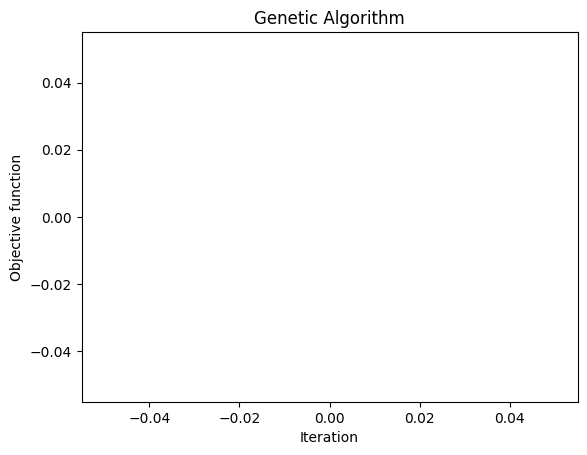


                           player_id        pos     pts
2                  aaron-cruden-1439   Fly Half  1392.0
4              aaron-grandidier-4678       Wing     0.0
5                    aaron-gray-3113     Centre    88.0
7                    aaron-juma-5327     Hooker     0.0
9                aaron-mitchell-4307       Prop     0.0
12               aaron-stafford-4935     Centre    12.0
13                   aaron-tull-5422  Third Row     0.0
15  abdulkhalik-akuenzaalkareem-5361  Third Row     0.0
16         abongile-nonkontwana-3231  Third Row    30.0
18                 abraham-pole-5041       Prop    25.0
19                    adam-ashe-2492  Third Row    75.0
21                   adam-byrne-2772     Centre   145.0
22                 adam-channel-4985       Wing    15.0
23                 adam-coleman-2898       Lock    40.0
24                adam-hastings-3657   Fly Half   631.0


In [ ]:

# Step 1: Ensure unique player_id by aggregating the data and include 'pos' from the dataset
def aggregate_player_data(data):
    # Aggregating the points and other necessary data based on unique player_id
    aggregated_data = data.groupby('player_id').agg({
        'pts': 'sum',        # Sum of points scored
        'min': 'mean',       # Average minutes played
        'pos': 'first'       # Player position from the dataset (assuming this is a string or category)
    }).reset_index()

    return aggregated_data

# Now use this function to get a unique player_id dataset
unique_player_data = aggregate_player_data(player_data)

# Step 2: Optimize the team performance using the unique player data

# Function to define the objective for optimization based on general performance metrics
def optimize_team_performance(data, metric='pts', team_size=15):
    # Define the objective function for the genetic algorithm
    def team_performance(x):
        selected_players = np.where(x == 1)[0]  # Select players for the lineup

        if len(selected_players) != team_size:
            return np.inf  # Penalize solutions that don't have exactly 'team_size' players

        # Extract the positions of the selected players from the 'pos' column
        selected_positions = data.iloc[selected_players]['pos']

        # Check if all positions are unique
        if len(selected_positions) != len(selected_positions.unique()):
            return np.inf  # Penalize solutions with duplicate positions

        # Calculate the total metric (e.g., points) for the selected players
        team_metric = data.iloc[selected_players][metric].sum()
        return -team_metric  # Genetic algorithm minimizes, so return negative

    # Set the variable boundaries for the optimization (0 or 1 for each player)
    varbound = np.array([[0, 1]] * len(data))

    algorithm_param = {
            'max_num_iteration': 200,          # Increase the number of iterations
            'population_size': 50,             # Increase the population size to explore more lineups
            'mutation_probability': 0.3,       # Increase mutation rate for more diversity
            'elit_ratio': 0.05,                # Retain top 5% of solutions
            'crossover_probability': 0.6,      # Adjust crossover probability for better combination of solutions
            'parents_portion': 0.4,            # 40% of population used as parents for next generation
            'crossover_type': 'uniform',
            'max_iteration_without_improv': 20 # Stop after 20 iterations without improvement
        }

    # Run the genetic algorithm for the chosen metric (e.g., points)
    model = ga(function=team_performance, dimension=len(data), variable_type='int', variable_boundaries=varbound, algorithm_parameters=algorithm_param)
    model.run()

    # Get the optimized lineup (ensures it only contains exactly 15 players with unique positions)
    optimized_lineup = np.where(model.output_dict['variable'] == 1)[0]
    if len(optimized_lineup) > team_size:
        optimized_lineup = optimized_lineup[:team_size]  # Ensure we take exactly 15 players

    # Return the optimized lineup including player_id, position ('pos'), and chosen metric (e.g., points)
    return data.iloc[optimized_lineup][['player_id', 'pos', metric]]

# Step 3: Example - Optimize the team based on points scored
optimal_lineup_pts = optimize_team_performance(unique_player_data, metric='pts', team_size=15)
print("Optimal lineup based on points scored:")
print(optimal_lineup_pts[['player_id', 'pos', 'pts']])

### 3. Optimisation based on different scenarios
Modify the objective function to optimize for different metrics.

__________________________________________________ 0.2% GA is running...

/usr/local/lib/python3.10/dist-packages/geneticalgorithm/geneticalgorithm.py:353: RuntimeWarning: invalid value encountered in subtract
  normobj=maxnorm-normobj+1


 The best solution found:
 [0. 1. 0. ... 1. 0. 0.]

 Objective function:
 inf


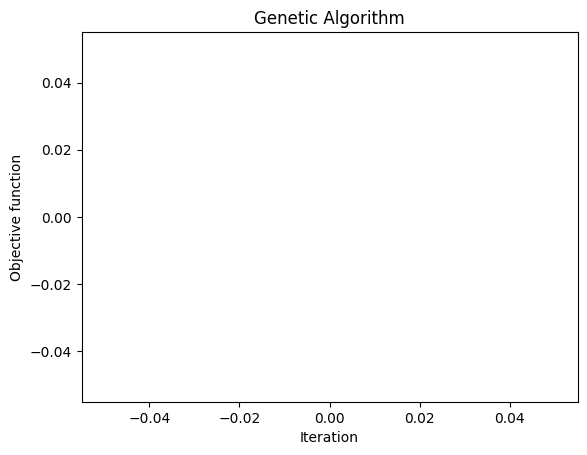


                    player_id        pos   try   tr
1          aaron-carroll-2795       Lock   4.0  0.0
3         aaron-cummings-5215  Third Row   0.0  0.0
4       aaron-grandidier-4678       Wing   0.0  0.0
6          aaron-hinkley-4235  Third Row   5.0  0.0
7             aaron-juma-5327     Hooker   0.0  0.0
8         aaron-matthews-4936   Fly Half   3.0  0.0
9         aaron-mitchell-4307       Prop   0.0  0.0
10          aaron-morris-3080       Wing  15.0  0.0
12        aaron-stafford-4935     Centre   0.0  3.0
14     abdelkarim-fofana-4369       Lock  11.0  1.0
16  abongile-nonkontwana-3231  Third Row   6.0  0.0
17       abraham-papalii-3690  Third Row  15.0  2.0
19             adam-ashe-2492  Third Row  15.0  0.0
20      adam-brocklebank-3976       Prop   0.0  0.0
23          adam-coleman-2898       Lock   8.0  0.0


In [ ]:
# Step 1: Ensure unique player_id by aggregating the data and include 'pos' from the dataset
def aggregate_player_data(data):
    # Aggregating the defensive metrics and other necessary data based on unique player_id
    aggregated_data = data.groupby('player_id').agg({
        'try': 'sum',        # Sum of tries (for defensive metric)
        'tr': 'sum',         # Sum of turnovers (for defensive metric)
        'min': 'mean',       # Average minutes played
        'pos': 'first'       # Player position from the dataset (assuming this is a string or category)
    }).reset_index()

    return aggregated_data

# Now use this function to get a unique player_id dataset
unique_player_data = aggregate_player_data(player_data)

# Step 2: Optimize the team performance for defense using the unique player data

# Function to define the objective for optimization based on defense metrics
def optimize_team_for_defense(data, team_size=15):
    # Define the objective function for the genetic algorithm
    def defense_focused_performance(x):
        selected_players = np.where(x == 1)[0]  # Select players for the lineup

        if len(selected_players) != team_size:
            return np.inf  # Penalize solutions that don't have exactly 'team_size' players

        # Extract the positions of the selected players from the 'pos' column
        selected_positions = data.iloc[selected_players]['pos']

        # Check if all positions are unique
        if len(selected_positions) != len(selected_positions.unique()):
            return np.inf  # Penalize solutions with duplicate positions

        # Calculate the total defensive metric (e.g., tries + turnovers) for the selected players
        team_defense = data.iloc[selected_players]['try'].sum() + data.iloc[selected_players]['tr'].sum()
        return -team_defense  # Genetic algorithm minimizes, so return negative

    # Set the variable boundaries for the optimization (0 or 1 for each player)
    varbound = np.array([[0, 1]] * len(data))

    # Set the parameters for the genetic algorithm
    algorithm_param = {
        'max_num_iteration': 500,
        'population_size': 20,  # Adjust as needed
        'mutation_probability': 0.1,
        'elit_ratio': 0.01,
        'crossover_probability': 0.5,
        'parents_portion': 0.3,
        'crossover_type': 'uniform',
        'max_iteration_without_improv': 10
    }

    # Run the genetic algorithm for defense
    model = ga(function=defense_focused_performance, dimension=len(data), variable_type='int', variable_boundaries=varbound, algorithm_parameters=algorithm_param)
    model.run()

    # Get the optimized defensive lineup (ensures it only contains exactly 15 players with unique positions)
    optimized_lineup = np.where(model.output_dict['variable'] == 1)[0]
    if len(optimized_lineup) > team_size:
        optimized_lineup = optimized_lineup[:team_size]  # Ensure we take exactly 15 players

    # Return the optimized lineup including player_id, position ('pos'), and defensive metrics (try, tr)
    return data.iloc[optimized_lineup][['player_id', 'pos', 'try', 'tr']]

# Step 3: Example - Optimize the team based on defensive performance (tries + turnovers)
optimal_lineup_defense = optimize_team_for_defense(unique_player_data, team_size=15)
print("Optimal lineup based on defense (tries + turnovers):")
print(optimal_lineup_defense[['player_id', 'pos', 'try', 'tr']])


### 4. Results generation

__________________________________________________ 0.5% GA is running...

/usr/local/lib/python3.10/dist-packages/geneticalgorithm/geneticalgorithm.py:353: RuntimeWarning: invalid value encountered in subtract
  normobj=maxnorm-normobj+1


 The best solution found:
 [1. 1. 1. ... 0. 1. 1.]

 Objective function:
 inf


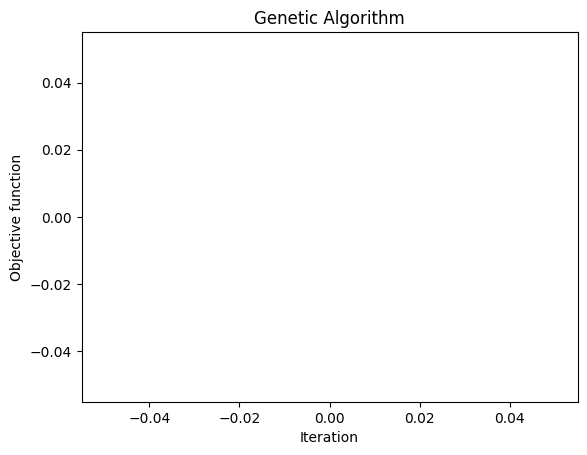


__________________________________________________ 0.2% GA is running...

/usr/local/lib/python3.10/dist-packages/geneticalgorithm/geneticalgorithm.py:353: RuntimeWarning: invalid value encountered in subtract
  normobj=maxnorm-normobj+1


 The best solution found:
 [1. 0. 1. ... 0. 1. 0.]

 Objective function:
 inf


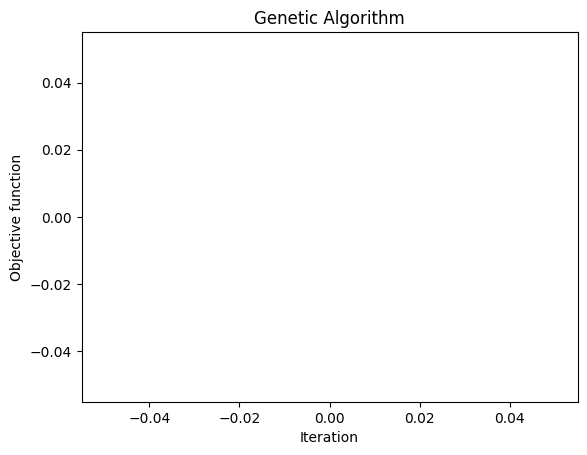


Optimal Offensive Lineup:
              player_id         pos   pts
0   esteban-abadie-4289   Third Row   0.0
1   esteban-abadie-4289   Third Row   0.0
2   esteban-abadie-4289   Third Row  10.0
4   esteban-abadie-4289   Third Row   0.0
6   esteban-abadie-4289   Third Row   0.0
8      paul-abadie-3015  Scrum half   0.0
10     paul-abadie-3015  Scrum half   0.0
11     paul-abadie-3015  Scrum half   0.0
12     paul-abadie-3015  Scrum half  52.0
14     paul-abadie-3015  Scrum half  10.0
18     paul-abadie-3015  Scrum half   8.0
19     paul-abadie-3015  Scrum half  14.0
21     paul-abadie-3015  Scrum half   0.0
22     paul-abadie-3015  Scrum half   0.0
26   mathieu-acebes-621        Wing  23.0

Optimal Defensive Lineup:
              player_id         pos  try   tr
0   esteban-abadie-4289   Third Row  0.0  0.0
2   esteban-abadie-4289   Third Row  2.0  0.0
4   esteban-abadie-4289   Third Row  0.0  0.0
5   esteban-abadie-4289   Third Row  0.0  0.0
6   esteban-abadie-4289   Third Row  0.0  0.

In [ ]:
# Function to generate a report
def generate_report(data):
    # Get optimal offensive and defensive lineups
    optimal_offensive = optimize_team_performance(data, metric='pts')
    optimal_defensive = optimize_team_for_defense(data)

    # Create a report
    report = {
        'Optimal Offensive Lineup': optimal_offensive,
        'Optimal Defensive Lineup': optimal_defensive
    }

    # Print or save the report
    for scenario, lineup in report.items():
        print(f"\n{scenario}:")
        print(lineup)

# Example: Generate the report
generate_report(player_data)